# <font color='green'>Lending Club Case Study</font>
<font color='red' size='1'>* html bookmarks (used in this notebook - for jumping to references) will work only after all cells have been compiled once </font>

# Data Sourcing

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import chardet
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')

In [105]:
# few settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# read file
loan = pd.read_csv("loan.csv", encoding = "ISO-8859-1")
loan_copy=loan.copy()
print(loan.shape)

(39717, 111)


# Data Cleaning and Manipulation

In [106]:
# check datatypes 
loan.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [107]:
# get the distinct count for variables of object type
loan.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                       2
int_rate                 371
grade                      7
sub_grade                 35
emp_title              28820
emp_length                11
home_ownership             5
verification_status        3
issue_d                   55
loan_status                3
pymnt_plan                 1
url                    39717
desc                   26527
purpose                   14
title                  19615
zip_code                 823
addr_state                50
earliest_cr_line         526
revol_util              1089
initial_list_status        1
last_pymnt_d             101
next_pymnt_d               2
last_credit_pull_d       106
application_type           1
dtype: int64

### Find and drop all columns that are not significant

<font color='blue'> - columns with all uniques values</font><br/>
<font color='blue'> - columns with all null values</font><br/>
<font color='blue'> - columns with just 1 distinct value</font><br/>

In [108]:
print('Shape of the dataframe at the very start is {0}'.format(loan.shape))

Shape of the dataframe at the very start is (39717, 111)


In [109]:
# loop through each column and drop all columns that are not significant .. 
#    all unique values, all null values, those with just 1 distinct value
alluniquevalues = []
onlyonevalue = []
allblankvalues = []

for name in loan.columns:
    col=loan[name].copy()
    if type(col) in ['int64', 'float64']:
        col=col.replace('', np.nan)
        col=col.replace('na', np.nan)
        col=col.replace('NA', np.nan)
    else:
        col=col.replace('', None)
        col=col.replace('', None)
    if col.nunique() == 39717:
        alluniquevalues.append(name)
        # loan=loan.drop(name, axis=1)    
    if col.nunique() == 0:
        allblankvalues.append(name)
        loan=loan.drop(name, axis=1)
    if col.nunique() == 1:
        onlyonevalue.append(name)        
        loan=loan.drop(name, axis=1)

In [110]:
# Also get columns with only 2 distinct values
# and list columns with object data-type for further processing
onlytwovalues = []
objectDTvariables = []

for name in loan.columns:
    col=loan[name].copy()
    if type(col) in ['int64', 'float64']:
        col=col.replace('', np.nan)
        col=col.replace('na', np.nan)
        col=col.replace('NA', np.nan)
    else:
        col=col.replace('', None)
        col=col.replace('', None)

    if col.nunique() == 2:
        onlytwovalues.append(name)
    
    if col.dtype == 'object':
        objectDTvariables.append(name +'|'+ str(col.nunique()))

In [111]:
# print and record columns that were dropped above
print('---all unique values---')
print(alluniquevalues)      
print()      
print('--- all blank values---')
print(allblankvalues)      
print()        
print('---only one value---')
print(onlyonevalue)      
print()   

---all unique values---
['id', 'member_id', 'url']

--- all blank values---
['mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot

In [112]:
# print and record columns that have just 2 distinct values and those with object datatype 
print('--- only two values---')
print(onlytwovalues)      
print()      
print('--- variables with object DT ---')
print(objectDTvariables)      
print()   

--- only two values---
['term', 'next_pymnt_d']

--- variables with object DT ---
['term|2', 'int_rate|371', 'grade|7', 'sub_grade|35', 'emp_title|28820', 'emp_length|11', 'home_ownership|5', 'verification_status|3', 'issue_d|55', 'loan_status|3', 'url|39717', 'desc|26527', 'purpose|14', 'title|19615', 'zip_code|823', 'addr_state|50', 'earliest_cr_line|526', 'revol_util|1089', 'last_pymnt_d|101', 'next_pymnt_d|2', 'last_credit_pull_d|106']



#### Remove columns with more than 60% missing data

In [113]:
# remove columns with more than 60% missing data
# print(round(100*(loan.isnull().sum()/len(loan.index)),2))
s=(round(100*(loan.isnull().sum()/len(loan.index)),2))
sdf=s.to_frame()
sdf=sdf.rename(columns = {0:'Perc'})
sdf=sdf[sdf['Perc']>60]
sdf

,Perc
mths_since_last_delinq,64.66
mths_since_last_record,92.99
next_pymnt_d,97.13


In [114]:
# drop 3 such columns - mths_since_last_delinq, mths_since_last_record, next_pymnt_d'
loan=loan.drop('mths_since_last_delinq', axis=1)
loan=loan.drop('mths_since_last_record', axis=1)
loan=loan.drop('next_pymnt_d', axis=1)

print('Dropped 3 such columns - mths_since_last_delinq, mths_since_last_record, next_pymnt_d')

Dropped 3 such columns - mths_since_last_delinq, mths_since_last_record, next_pymnt_d


#### Remove columns which seem to have not much significance

In [115]:
# Remove columns which seem to have not much significance
print('Dropped less significant columns: url, desc, emp_title, title, zip_code', 'id')
loan=loan.drop('url', axis=1)
loan=loan.drop('desc', axis=1)
loan=loan.drop('emp_title', axis=1)
loan=loan.drop('title', axis=1)
loan=loan.drop('zip_code', axis=1)
loan=loan.drop('id', axis=1)

Dropped less significant columns: url, desc, emp_title, title, zip_code id


In [116]:
print('Shape of the dataframe, after dropping columns is {0}'.format(loan.shape))

Shape of the dataframe, after dropping columns is (39717, 39)


In [117]:
# list the remaining columns
# loan.info()

#### So, by now we have reduced columns from 111 to 39

#### Find columns that have categories and can be segmented

In [118]:
# find columns that have categories and can be segmented
for name in loan.columns:
    col=loan[name].copy()
    if type(col) in ['int64', 'float64']:
        col=col.replace('', np.nan)
        col=col.replace('na', np.nan)
        col=col.replace('NA', np.nan)
    else:
        col=col.replace('', None)
        col=col.replace('', None)
        
    if col.nunique() <= 50 and col.nunique() > 1:
        print('--- {0} ---'.format(name))
        print(col.unique())

--- term ---
[' 36 months' ' 60 months']
--- grade ---
['B' 'C' 'A' 'E' 'F' 'D' 'G']
--- sub_grade ---
['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5'
 'G4' 'E2' 'G3' 'G2' 'G1' 'F5' 'G5']
--- emp_length ---
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]
--- home_ownership ---
['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']
--- verification_status ---
['Verified' 'Source Verified' 'Not Verified']
--- loan_status ---
['Fully Paid' 'Charged Off' 'Current']
--- purpose ---
['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
--- addr_state ---
['AZ' 'GA' 'IL' 'CA' 'OR' 'NC' 'TX' 'VA' 'MO' 'CT' 'UT' 'FL' 'NY' 'PA'
 'MN' 'NJ' 'KY' 'OH' 'SC' 'RI' 'LA' 'MA' 'WA' 'WI' 'AL' 'CO' 'KS' 'NV'
 'AK' 'MD' 'WV' 'VT

#### Lets observe some of the variables with object data-type 
### Check if casting and cleaning is required

In [119]:
# Lets look at 'int_rate' object column
loan.int_rate.head()

0    10.65%
1    15.27%
2    15.96%
3    13.49%
4    12.69%
Name: int_rate, dtype: object

In [120]:
# replace % and convert to to float (using lambda)
loan['int_rate']=loan['int_rate'].apply(lambda x:float(x.replace('%','')))
loan.int_rate.head()

0   10.65
1   15.27
2   15.96
3   13.49
4   12.69
Name: int_rate, dtype: float64

In [121]:
# Lets look at 'emp_length' object column
loan.emp_length.value_counts()

10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: emp_length, dtype: int64

In [122]:
# replace non digits and convert to float (using lambda)
loan['emp_length'].replace(to_replace='< 1', value='0', inplace=True)
loan['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)

In [123]:
# impute NAN with 0 and cast it to integer type
loan['emp_length'].fillna(value=0,inplace=True)
loan['emp_length']=loan['emp_length'].astype(int)
loan['emp_length'].dtype

dtype('int64')

In [124]:
loan.emp_length.value_counts()

10    8879
1     7823
2     4388
3     4095
4     3436
5     3282
6     2229
7     1773
8     1479
9     1258
0     1075
Name: emp_length, dtype: int64

In [125]:
# Lets look at 'revol_util' object column
loan.revol_util.value_counts()

0%        977
0.20%      63
63%        62
40.70%     58
66.70%     58
         ... 
0.86%       1
8.46%       1
29.77%      1
25.74%      1
8.58%       1
Name: revol_util, Length: 1089, dtype: int64

In [126]:
# replace % and convert to to float (using lambda)
loan['revol_util']=loan['revol_util'].apply(lambda x:float(str(x).replace('%','')))
loan.int_rate.head()

0   10.65
1   15.27
2   15.96
3   13.49
4   12.69
Name: int_rate, dtype: float64

In [127]:
# loan.info()

#### <font color='blue'>At this point all irrelevant columns have been removed and data-types of all columns seems okay</font>

### Remaining columns to work with
|Column|Desciption|
| --- | --- |
|loan_amnt|amount of the loan applied for by the borrower|
|funded_amnt|total amount committed to that loan|
|funded_amnt_inv|total amount committed by investors for that loan|
|int_rate|Interest Rate on the loan|
|installment|monthly payment owed by the borrower|
|emp_length|Employment length in years|
|annual_inc|annual income of the borrower|
|dti|(total monthly debt payments) / (monthly income)|
|delinq_2yrs|number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years|
|inq_last_6mths|number of inquiries in past 6 months (excluding auto and mortgage inquiries)|
|open_acc|number of open credit lines in the borrower's credit file|
|pub_rec|Number of derogatory public records|
|pub_rec_bankruptcies|Number of public record bankruptcies|
|revol_bal|Total credit revolving balance|
|revol_util|Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit|
|total_acc|total number of credit lines currently in the borrower's credit file|
|out_prncp|Remaining outstanding principal for total amount funded|
|out_prncp_inv|Remaining outstanding principal for portion of total amount funded by investors|
|total_pymnt|Payments received to date for total amount funded|
|total_pymnt_inv|Payments received to date for portion of total amount funded by investors|
|total_rec_prncp|Principal received to date|
|total_rec_int|Interest received to date|
|total_rec_late_fee|Late fees received to date|
|recoveries|post charge off gross recovery|
|collection_recovery_fee|post charge off collection fee|
|last_pymnt_amnt|Last total payment amount received|
|term|number of payments on the loan (36/60)|
|grade|assigned loan grade A-G|
|sub_grade|assigned loan subgrade 1-5 each for each grade|
|home_ownership|home ownership status provided by the borrower|
|verification_status|if borrower's income was verified by LC, not verified, or if the income source was verified|
|loan_status|Current status of the loan|
|purpose|purpose for loan|
|addr_state|borrower's state|
|earliest_cr_line|month the borrower's earliest reported credit line was opened|
|last_credit_pull_d|most recent month LC pulled credit for this loan|
|last_pymnt_d|Last month payment was received|
|issue_d|month which the loan was funded|

# Data Analysis

### Univariate Analysis - Continuous Variables
<font color='brown'>For variables: int_rate, annual_inc, loan_amnt, installament, dti, revol_util<br/><br/>
UDF <strong>drawContinuousVarPlot:</strong><br/>This renders Distribution and Box plots side-by-side 
</font>

In [128]:
def drawContinuousVarPlot(df, col, colTitle, fgs, whichPlot=12):
  fig, ax=plt.subplots(1,2,figsize=fgs)
  if whichPlot == 1: 
    sns.distplot(df[col], ax=ax[0])
  elif whichPlot == 2: 
    sns.boxplot(data=df, x=col, ax=ax[1], orient='v')
  elif whichPlot == 12: 
    sns.distplot(df[col], ax=ax[0]),
    sns.boxplot(data=df, x=col, ax=ax[1], orient='v')
  
  plt.show()

<hr style="height:1px;border:none;color:#333;background-color:#333;">
<font color='blue'>Interest Rate</font>

In [129]:
loan['int_rate'].describe()

count   39717.00
mean       12.02
std         3.72
min         5.42
25%         9.25
50%        11.86
75%        14.59
max        24.59
Name: int_rate, dtype: float64

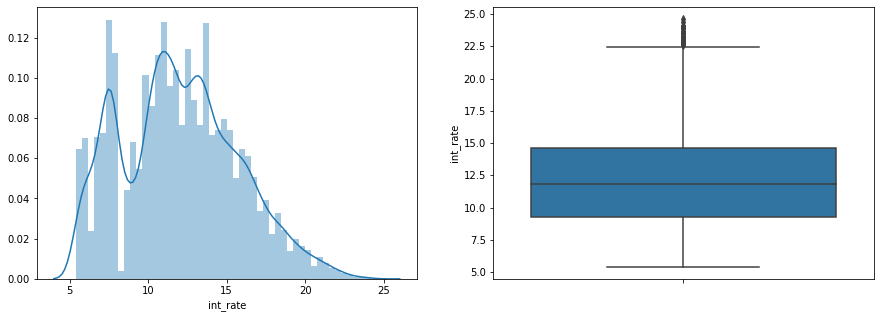

In [130]:
drawContinuousVarPlot(loan, 'int_rate', 'Interest Rate', (15,5))

#### Observation: 
<font color='blue'>Most Loans belong to Interest-Rate range of 9-15%</font>
<br/><a href=#Correlation_Matrix><font color='brown'>Click here for its co-relation with Loan Status in MultiVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">
<font color='blue'>Annual Income</font>

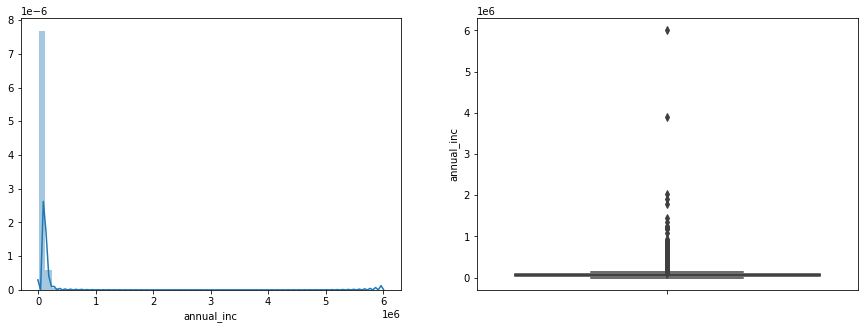

In [131]:
drawContinuousVarPlot(loan, 'annual_inc', 'Annual Income', (15,5))

<font color='blue'>Lot of outliers around. Lets try cleaning beyond 99%</font>

In [132]:
loan['annual_inc'].describe()

count     39717.00
mean      68968.93
std       63793.77
min        4000.00
25%       40404.00
50%       59000.00
75%       82300.00
max     6000000.00
Name: annual_inc, dtype: float64

In [133]:
# 99th percentile i.e. beyond which are top 1% 
v99th=loan['annual_inc'].quantile(0.99)
print("99th percentile i.e. beyond which are top 1% is {0}".format(v99th))

loan=loan[loan['annual_inc'] < v99th]
loan['annual_inc'].describe()

99th percentile i.e. beyond which are top 1% is 234999.36


count    39319.00
mean     65524.22
std      35215.89
min       4000.00
25%      40000.00
50%      58000.00
75%      81000.00
max     234996.00
Name: annual_inc, dtype: float64

In [134]:
print('Number of observations after removing 1% of them is {0}'.format(loan.shape[0]))

Number of observations after removing 1% of them is 39319


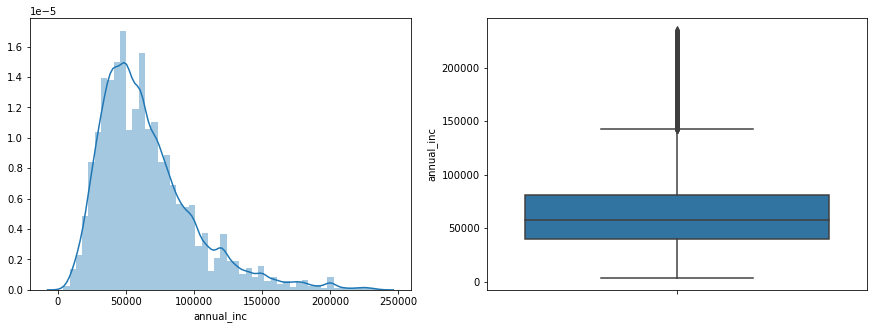

In [135]:
drawContinuousVarPlot(loan, 'annual_inc', 'Annual Income', (15,5))

#### Observation: 
<font color='blue'>Most loans belong to the Anual-Income range of 40,000 to 80,000 USD</font>
<br/><a href=#Correlation_Matrix><font color='brown'>Click here for its co-relation with Loan Status in MultiVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">
<font color='blue'>Loan Amount</font>

In [136]:
loan['loan_amnt'].describe()

count   39319.00
mean    11134.11
std      7376.09
min       500.00
25%      5400.00
50%     10000.00
75%     15000.00
max     35000.00
Name: loan_amnt, dtype: float64

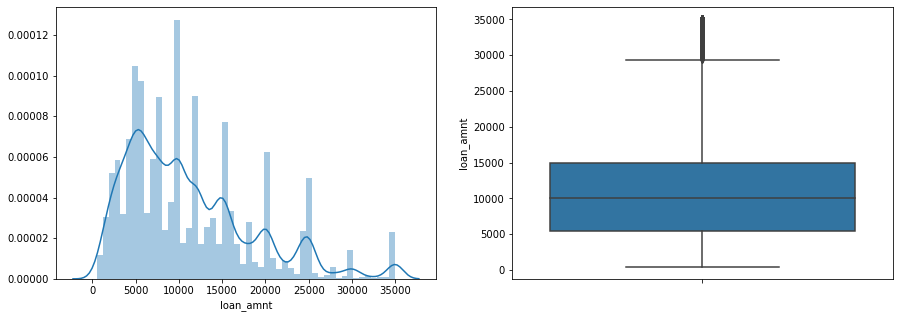

In [137]:
drawContinuousVarPlot(loan, 'loan_amnt', 'Loan Amount', (15,5))

#### Observation: 
<font color='blue'>Most loans belong to Loan-Amount range 5,000 to 15,000 USD</font>
<br/><a href=#Correlation_Matrix><font color='brown'>Click here for its co-relation with Loan Status in MultiVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">
<font color='blue'>Debt-to-Income ratio</font>

In [138]:
loan['dti'].describe()

count   39319.00
mean       13.38
std         6.66
min         0.00
25%         8.27
50%        13.48
75%        18.64
max        29.99
Name: dti, dtype: float64

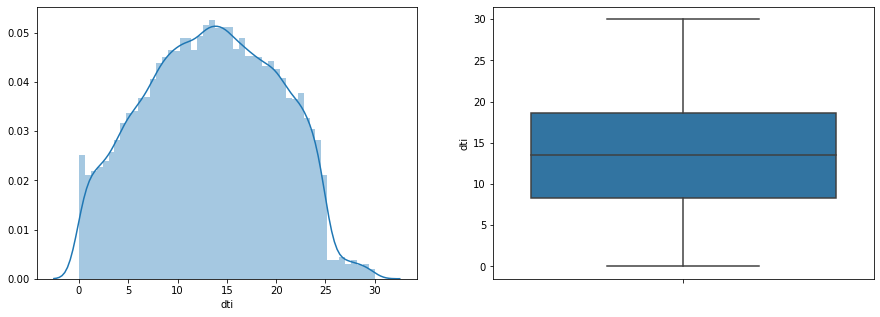

In [139]:
drawContinuousVarPlot(loan, 'dti', 'Debt to Income', (15,5))

#### Observation: 
<font color='blue'>Debt-to-income ratio for most loans is in the range of 7 to 18</font>
<br/><a href=#Correlation_Matrix><font color='brown'>Click here for its co-relation with Loan Status in MultiVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">
<font color='blue'>Installment</font>

In [140]:
loan['installment'].describe()

count   39319.00
mean      322.02
std       206.21
min        15.69
25%       166.19
50%       278.92
75%       426.10
max      1305.19
Name: installment, dtype: float64

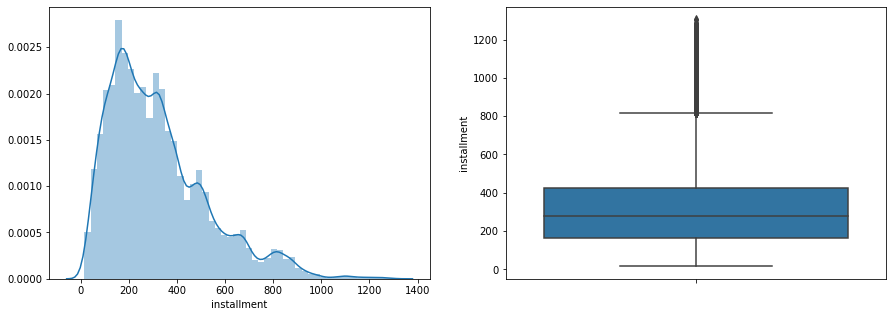

In [141]:
drawContinuousVarPlot(loan, 'installment', 'installment', (15,5))

#### Observation: 
<font color='blue'>Installment typically range: 200 - 400 USD</font>
<br/><a href=#Correlation_Matrix><font color='brown'>Click here for its co-relation with Loan Status in MultiVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">
<font color='blue'>Revolving Credit</font>

In [142]:
loan['revol_util'].describe()

count   39270.00
mean       48.82
std        28.31
min         0.00
25%        25.40
50%        49.30
75%        72.30
max        99.90
Name: revol_util, dtype: float64

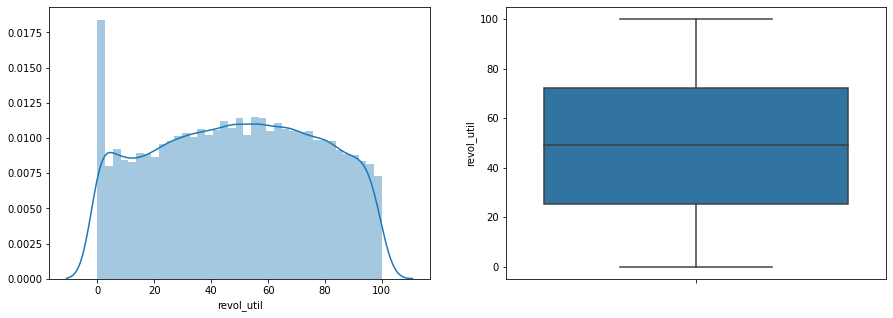

In [143]:
drawContinuousVarPlot(loan, 'revol_util', 'Revolving Credit Util', (15,5))

#### Observation: 
<font color='blue'>Many dont seem to utilize the Revolving-credit feature at all, whereas those who, seems to typically utilze 25-70% of the revolving-credit available</font>
<br/><a href=#Correlation_Matrix><font color='brown'>Click here for its co-relation with Loan Status in MultiVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

### Univariate Analysis - Categorical Variables
<font color='brown'>For term, grade, emp_length, home_ownership, verification_status, purpose, addr_state</font>

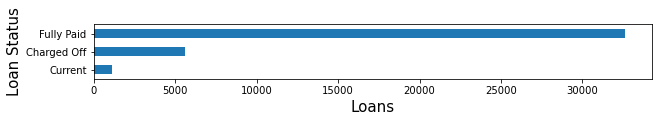

In [144]:
loan['loan_status'].value_counts().sort_values().plot(kind='barh',figsize=(10,1))
plt.xlabel('Loans',fontsize=15)
plt.ylabel('Loan Status',fontsize=15);

#### Observation: 
<font color='blue'>Since the exercise is to find the possible driving parameters for loan default; a metric can be derived from this as below - wherein, 1 => ChargedOff and 0 => Non-default </font>

#### <font color='green'>Derived Metric - chargedoff</font>

In [145]:
# check percent wise split of 3 segment values of loan_status
loan['loan_status'].value_counts()/len(loan.index)

Fully Paid    0.83
Charged Off   0.14
Current       0.03
Name: loan_status, dtype: float64

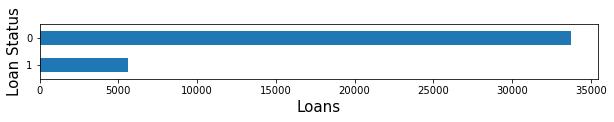

In [146]:
# Since Current is relatively very less in number, lets treat it in non-default category
chargedoff_list = ['1' if i=='Charged Off' else '0' for i in loan['loan_status']]

loan['chargedoff'] = chargedoff_list
loan['chargedoff'].value_counts().sort_values().plot(kind='barh',figsize=(10,1))

plt.xlabel('Loans',fontsize=15)
plt.ylabel('Loan Status',fontsize=15);

<hr style="height:1px;border:none;color:#333;background-color:#333;">

<font color='brown'>UDF: <strong>drawCountPlot</strong> and <strong>drawBarPlot</strong></font>

In [147]:
def drawCountPlot(df, col, colTitle, fgs):
  plt.figure(figsize=fgs)
  sns.countplot(data=df, x=col, order=df[col].value_counts().index, hue='chargedoff')
  plt.xlabel(colTitle,fontsize=15)
  plt.ylabel('Loans',fontsize=15)
  plt.show()

In [148]:
def drawBarPlot(df, col, colTitle, fgs):
  # A bar plot helps visualize a Series's value frequency using value_counts: s.value_counts().plot.bar()
  df[col].value_counts().sort_values().plot(kind='barh',figsize=fgs)
  plt.xlabel('Loans',fontsize=15)
  plt.ylabel(colTitle,fontsize=15)
  plt.show()

<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Bar-Term'>Bar-Term</a>

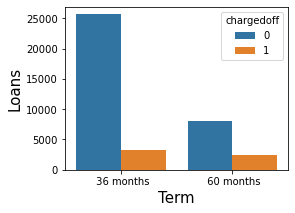

In [149]:
drawCountPlot(loan, 'term', 'Term', (4,3))

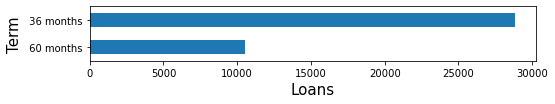

In [150]:
drawBarPlot(loan, 'term', 'Term', (8,1))

#### Observation: 
<font color='blue'>Maximum number of loans belong to 3 year term.<br/>However, the probability of default seems to be high for 60-month term</font><br/>
<a href=#Heatmap-Crosstab-Term><font color='brown'>Click here for Heatmap-Crosstab plot for Term in Bi/Multi Variate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Bar-Grade'>Bar-Grade</a>

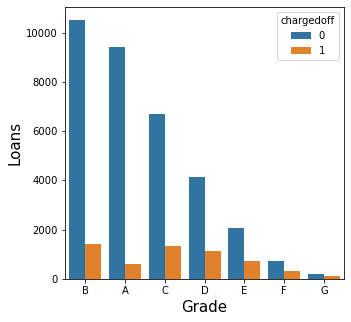

In [151]:
drawCountPlot(loan, 'grade', 'Grade', (5,5))

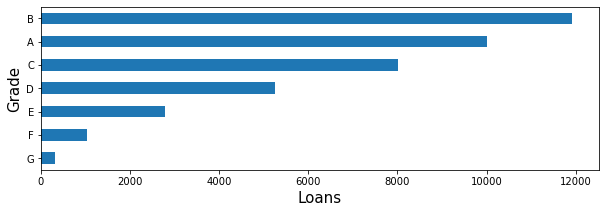

In [152]:
drawBarPlot(loan, 'grade', 'Grade', (10,3))

#### Observation: 
<font color='blue'>With an exception of Grade B; number of loans disbursed are proportional to grade.</font><br/><font color='red'>However, the probability of default, seems to increase according to loan <strong>grade</strong></font><br/><a href=#Heatmap-Crosstab-Grade><font color='brown'>Click here for Heatmap-Crosstab plot for Grade in Bi/Multi Variate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Bar-Employment_Year'>Bar-Employment Year</a>

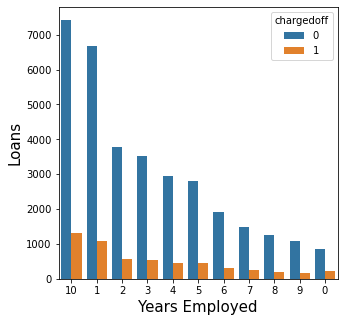

In [153]:
drawCountPlot(loan, 'emp_length', 'Years Employed', (5,5))

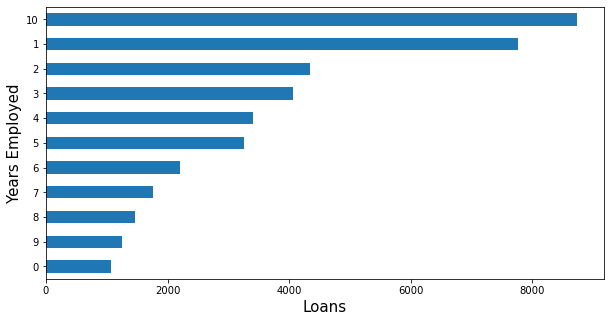

In [154]:
drawBarPlot(loan, 'emp_length', 'Years Employed', (10,5))

#### Observation: 
<font color='blue'>Loans tend to be taken proportionaly more in the early years of employment than later years.<br/>10 represents 10+ years hence seems an exception<br/>The probability of default seems to be higher for < 1  year employment-length category</font><br/><a href=#Heatmap-Crosstab-Employement_Year><font color='brown'>Click here for Heatmap-Crosstab plot for Employement-Year in Bi/Multi Variate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">
    
<a name='Bar-Home_Ownership'>Bar-Home Ownership</a>

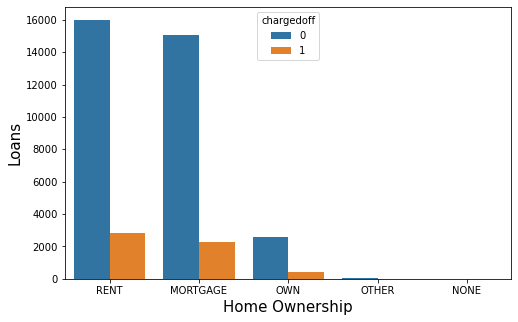

In [155]:
drawCountPlot(loan, 'home_ownership', 'Home Ownership', (8,5))

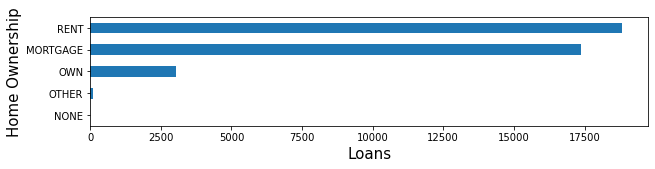

In [156]:
drawBarPlot(loan, 'home_ownership', 'Home Ownership', (10,2))

#### Observation: 
<font color='blue'>Those who DO NOT own homes and are on rent or have mortgaged; makes up most of the Loans</font><br/><a href=#Heatmap-Crosstab-Home_Ownership><font color='brown'>Click here for Heatmap-Crosstab plot for Home-Ownership in Bi/Multi Variate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Bar-Verification_Status'>Bar-Verification Status</a>

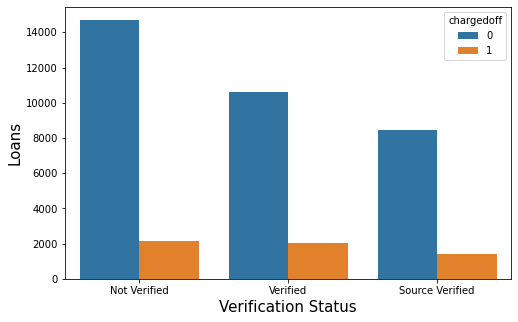

In [157]:
drawCountPlot(loan, 'verification_status', 'Verification Status', (8,5))

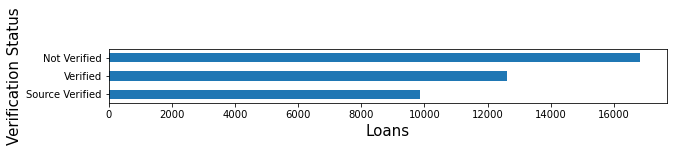

In [158]:
drawBarPlot(loan, 'verification_status', 'Verification Status', (10,1))

#### Observation: 
<font color='blue'>This shows significant number of loans have been given to borrowers without their income source verification</font><br/><a href=#Heatmap-Crosstab-Verification_Status><font color='brown'>Click here for Heatmap-Crosstab plot for Verification-Status in Bi/Multi Variate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Bar-Purpose'>Bar-Purpose</a>

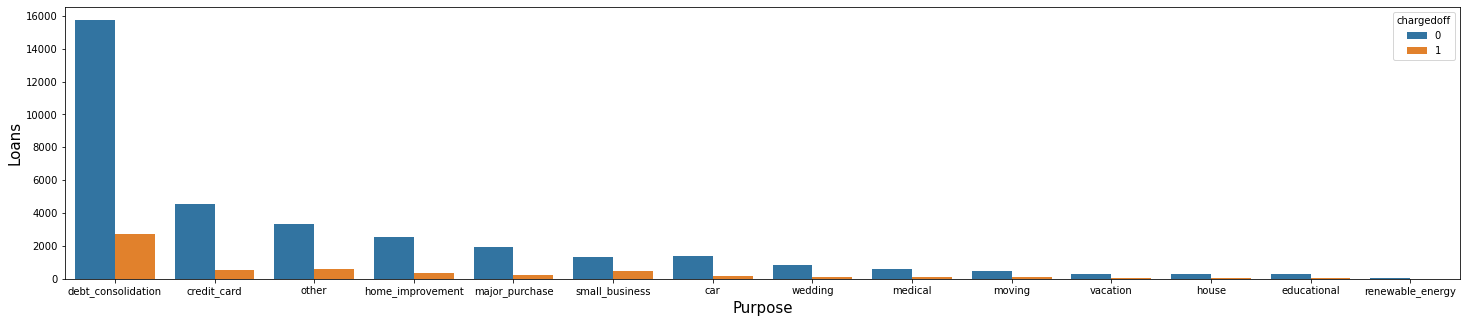

In [159]:
drawCountPlot(loan, 'purpose', 'Purpose', (25,5))

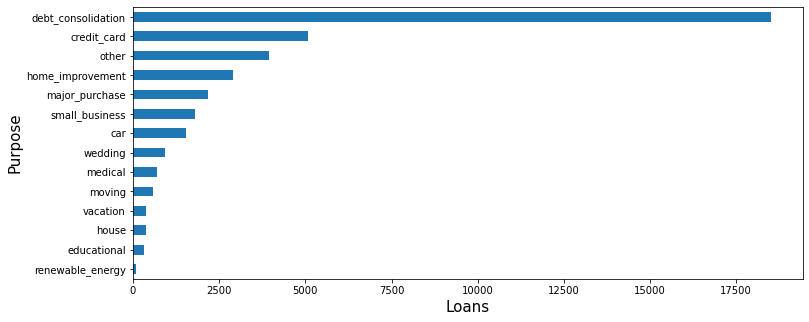

In [160]:
drawBarPlot(loan, 'purpose', 'Purpose', (12,5))

#### Observation: 
<font color='blue'>Debt consolidation and credit card payments seem to be the prominant reason for taking loan</font><br/><a href=#Heatmap-Crosstab-Purpose><font color='brown'>Click here for Heatmap-Crosstab plot for Purpose in Bi/Multi Variate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Bar-States'>Bar-States</a>

In [161]:
# instead of considering all 50 states lets filter out states that have borrowers taking loan more than 3% of total
s=(loan.addr_state.value_counts()/len(loan.index)*100)
sdf=s.to_frame()
sdf=sdf[sdf['addr_state']>3]
f_states_list = list(sdf.index)
sdf

,addr_state
CA,17.88
NY,9.55
FL,7.21
TX,6.85
NJ,4.64
PA,3.84
IL,3.83
VA,3.55
GA,3.53
MA,3.36


In [162]:
print(f_states_list)
loan_states=loan[ loan.addr_state.isin(f_states_list) ]

['CA', 'NY', 'FL', 'TX', 'NJ', 'PA', 'IL', 'VA', 'GA', 'MA', 'OH']


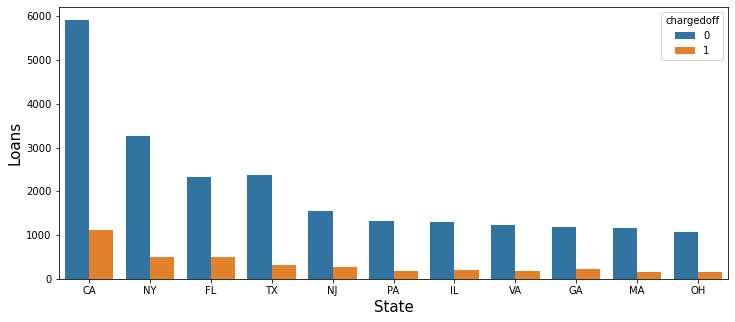

In [163]:
drawCountPlot(loan_states, 'addr_state', 'State', (12,5))

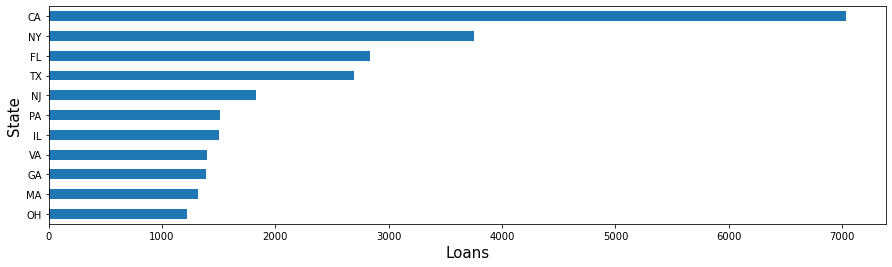

In [164]:
drawBarPlot(loan_states, 'addr_state', 'State', (15, 4))

#### Observation: 
<font color='blue'>States CA, NY, FL, TX have maximum loans borrowed</font><br/><a href=#Heatmap-Crosstab-States><font color='brown'>Click here for Heatmap-Crosstab plot for States in Bi/Multi Variate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

### Bivariate Analysis - Categorical Variables

#### <font color='blue'>Crosstab and Heatmap</font>
<font color='blue'>Categorical variables: term, grade, emp_length, home_ownership, verification_status, purpose, addr_state, chargedoff</font>

In [165]:
# pick categorical variables for crosstab analysis
loan_crosstab=loan[
  ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'chargedoff']
]

loan_crosstab.head()

,term,grade,emp_length,home_ownership,verification_status,purpose,addr_state,chargedoff
0,36 months,B,10,RENT,Verified,credit_card,AZ,0
1,60 months,C,1,RENT,Source Verified,car,GA,1
2,36 months,C,10,RENT,Not Verified,small_business,IL,0
3,36 months,C,10,RENT,Source Verified,other,CA,0
4,60 months,B,1,RENT,Source Verified,other,OR,0


### <font color='blue'>Derive a metric - chargedoff_prob </font>
<font color='brown' size=2>which will give better insights, when analyzed along with other variables</font>

In [166]:
# crosstab between 'term' and target variable 'chargedoff'
crosstab = pd.crosstab (
  index=[loan_crosstab.term], 
  columns=[loan_crosstab.chargedoff],
  margins=True
)
crosstab=crosstab[0:-1] # ignore last margin row
crosstab['chargedoff_prob']=round((crosstab['1']/crosstab['All']),3)
crosstab

chargedoff,0,1,All,chargedoff_prob
term,,,,
36 months,25619,3201,28820,0.11
60 months,8116,2383,10499,0.23


In [167]:
crosstab=crosstab[['chargedoff_prob']]
crosstab

chargedoff,chargedoff_prob
term,
36 months,0.11
60 months,0.23


<hr style="height:1px;border:none;color:#333;background-color:#333;">

<font color='brown'>UDF <strong>drawCrossTabHeatMap</strong>:<br/>This plots heatmap for crosstab between the given variable and the target variable 'chargedoff_prob'<font>

In [168]:
def drawCrossTabHeatMap( df, thecol, fgs ):
  crosstab = pd.crosstab(
    index=[df[thecol]], 
    columns=[df.chargedoff],
    margins=True
  )
  # ignore last margin row
  crosstab=crosstab[0:-1]

  # create a derived column showing probability of default on loan   
  crosstab['chargedoff_prob']=round((crosstab['1']/crosstab['All']),3)
  
  f, ax = plt.subplots(figsize=fgs)
  sns.heatmap(
    crosstab[['chargedoff_prob']].sort_values(by='chargedoff_prob',ascending=False),
    cmap='RdYlGn_r',
    annot= True
  )
  plt.show()

<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Heatmap-Crosstab-Term'>Heatmap-Crosstab-Term</a>

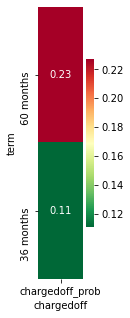

In [169]:
drawCrossTabHeatMap(loan_crosstab, 'term', (1, 5))

<a name='Term-Significant'></a>

#### Observation: 
<font color='blue'>Though Maximum number of loans belong to 3 year term,</font><br/><font color='red'>the probability of default is high for 60-month <strong>term</strong></font><br/>
<a href=#Bar-Term><font color='brown'>Click here for Bar plot for Term in UniVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Heatmap-Crosstab-Grade'>Heatmap-Crosstab-Grade</a>


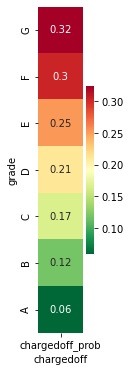

In [170]:
drawCrossTabHeatMap(loan_crosstab, 'grade', (1, 6))

<a name='Grade-Significant'></a>

#### Observation: 
<font color='blue'>Grade B was an exception to grab more number of loans than A.</font><br/><font color='red'>However, the probability of default increase according to loan <strong>grades</strong> A through G</font><br/><br/>
<a href=#Bar-Grade><font color='brown'>Click here for Bar plot for Grade in UniVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Heatmap-Crosstab-Employement_Year'>Heatmap-Crosstab-Employement Year</a>

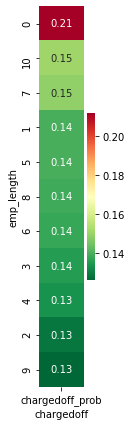

In [171]:
drawCrossTabHeatMap(loan_crosstab, 'emp_length', (1, 7))

<a name='Employment_Year-Significant'></a>

#### Observation: 
<font color='blue'>Loans tend to be taken proportionaly more in the early years of employment than later years.</font><br/><font color='red'>And the <strong>emp_length</strong> less than 1 year, carry high risk of default</font><br/>
<a href=#Bar-Employment_Year><font color='brown'>Click here for Bar plot for Employment Year in UniVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Heatmap-Crosstab-Home_Ownership'>Heatmap-Crosstab-Home Ownership</a>

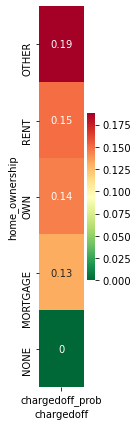

In [172]:
drawCrossTabHeatMap(loan_crosstab, 'home_ownership', (1, 7))

#### Observation: 
<font color='blue'>Even though, those who DO NOT own homes make up for the most number of Loans<br/>The probablity of default is at par with those who own house<br/></font><a href=#Bar-Home_Ownership><font color='brown'>Click here for Bar plot for Home Ownership in UniVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Heatmap-Crosstab-Verification_Status'>Heatmap-Crosstab-Verification Status</a>

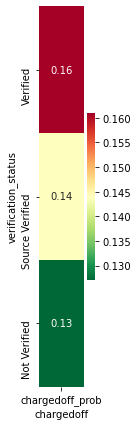

In [173]:
drawCrossTabHeatMap(loan_crosstab, 'verification_status', (1, 7))

#### Observation: 
<font color='blue'>Even though the significant number of loans have been given to borrowers without their income source verification;<br/>the probability of default is still lower than other categories</font><br/>
<a href=#Bar-Verification_Status><font color='brown'>Click here for Bar plot for Verification Status in UniVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Heatmap-Crosstab-Purpose'>Heatmap-Crosstab-Purpose</a>

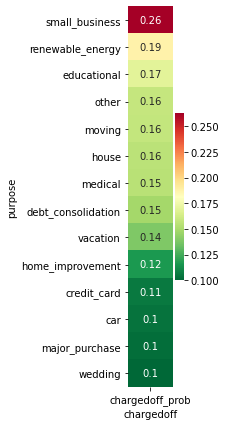

In [174]:
drawCrossTabHeatMap(loan_crosstab, 'purpose', (1, 7))

<a name='Purpose-Significant'></a>

#### Observation: 
<font color='blue'>Debt consolidation and credit card payments were the prominant reasons for taking loan<br/></font><font color='red'>However, <strong>Purpose</strong> that carries highest risk of default is <strong>small_business</strong><br/></font>
<a href=#Bar-Purpose><font color='brown'>Click here for Bar plot for Purpose in UniVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Heatmap-Crosstab-States'>Heatmap-Crosstab-State</a>

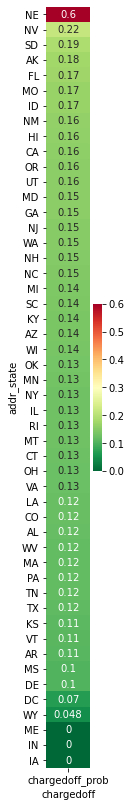

In [175]:
drawCrossTabHeatMap(loan_crosstab, 'addr_state', (1, 14))

<a name='States-Significant'></a>

#### Observation: 
<font color='blue'>States CA, NY, FL, TX have maximum loans borrowed<br/>However, the one that is by far the biggest contributor to default loans is NE - Nebraska</font><br/><br/>
<font color='red'>Though whole of the State cannot be defaulted; due to NE having high number of defaulters, <strong>addr_state</strong> need to be noted as one of the significant variable</font>
<a href=#Bar-States><font color='brown'>Click here for Bar plot for States in UniVariate section.</font></a>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

### Multivariate Analysis - Continuous Variables
#### <font color='blue'>Correlation and Heatmap</font>
<font color='blue'>Continuous variables: int_rate, annual_inc, loan_amnt, installament, dti, revol_util, chargedoff_int</font>
#### <font color='brown'>Lets derive the chargedoff_int out of chargedoff for using in correlation matrix</font>

In [176]:
# Lets derive the chargedoff_int out of chargedoff for using in correlation matrix
loan['chargedoff_int']=pd.to_numeric(loan.chargedoff)
print('Datatype of chargedoff derived metric is {0} converted to {1}'.format(
  loan.chargedoff.dtype,loan.chargedoff_int.dtype)
)

Datatype of chargedoff derived metric is object converted to int64


In [177]:
# pick numeric variables for correlation
loan_corr=loan[
  ['int_rate', 'annual_inc', 'loan_amnt', 'installment', 'dti', 'revol_util', 'chargedoff_int']
]

loan_corr.head(2)

,int_rate,annual_inc,loan_amnt,installment,dti,revol_util,chargedoff_int
0,10.65,24000.00,5000,162.87,27.65,83.70,0
1,15.27,30000.00,2500,59.83,1.00,9.40,1


<hr style="height:1px;border:none;color:#333;background-color:#333;">

<font color='brown'>UDF <strong>drawCorrHeatMap</strong>: <br/>This plots correlation heatmap between all numerical variables or between only chargedoff (the target variable) and other variables </font>

In [178]:
def drawCorrHeatMap(df, corr_cols='excludetarget', targetVariable='chargedoff_int' ):
  if corr_cols == 'onlytarget':
    df=df.corr()[[targetVariable]]
    f, ax = plt.subplots(figsize=(3, 10))
    sns.heatmap(
      df.sort_values(by=[targetVariable], ascending=True),
      vmin=-1, cmap='Blues', annot= True
    )
  elif corr_cols == 'excludetarget':
    df=df.loc[:,df.columns != targetVariable] # exclude the targetVariable
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(
      df.corr(), 
      vmin=-1, cmap='Blues', annot= True,
      xticklabels=df.columns.values,
      yticklabels=df.columns.values,
    )    
  elif corr_cols == 'all':
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(
      df.corr(), 
      vmin=-1, cmap='Blues', annot= True,
      xticklabels=df.columns.values,
      yticklabels=df.columns.values,
    )
    
  plt.show()

<hr style="height:1px;border:none;color:#333;background-color:#333;">

<font color='brown'>Correlation Matrix (excluding chargedoff_int for now)</font>

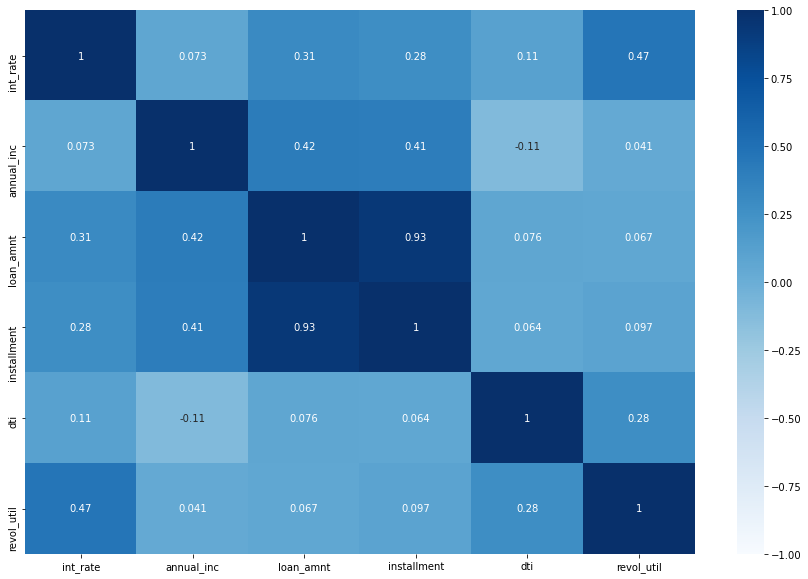

In [179]:
# Will exclude chargedoff_int for now ... 
# will analyze it separately, next, as it is the target variable
# To include even chargedoff_int column here, pass argument corr_cols='all'
drawCorrHeatMap(loan_corr) 

#### Observation: 
<font color='blue'>Most dense cluster is that among loan-amount, installment and annual-income</font>
<br/><font color='green'>As annual income increases, loan amount borrowed increases and so increase the installment amount</font>
<br/><font color='blue'>2nd dense relation is among debt-to-income ratio and utilization of revolving-credit</font>
<br/><font color='green'>As dti increase, the revol-credit utilization follows it</font>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<a name='Correlation_Matrix'></a><font color='brown'>Correlation Matrix (only chargedoff_int in relation with other variables)</font>

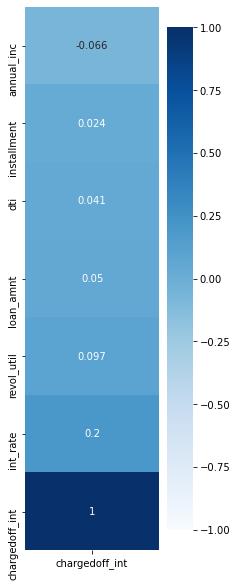

In [180]:
# target variable (chargedoff_int) in relation with other numeric variables
drawCorrHeatMap(loan_corr, corr_cols='onlytarget')

<a name='Interest_Rate-Significant'></a>

#### Observation: 
<font color='blue'>Loan Status is related positively with various variables in the following order: int_rate, annual_inc, loan_amnt, installment, dti, revol_util</font>
<br/><font color='green'>As Annual Income increase, the default rate decrease. Annual Income is negatively related to ChargedOff</font>
<br/><font color='brown'>More the interest-rate higher is the default rate</font>
<br/><font color='brown'>More the Loan Amount, higher is the chance to default.</font>
<br/><font color='brown'>High debt-to-income ratio implies higher the chance to default.</font>
<br/><font color='brown'>As person tends to default, his/her utilization of revolving credit tend to increase.</font>
<br/><br/><font color='brown'>All others except Interest-Rate, have <strong>loose</strong> positive correlation.</font><br/>
<font color='red'><strong>Interest-Rate</strong> has significant positive correlation to ChargedOff variable.</font>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

### BiVariate and Segmented Analysis (int_rate)
<br/><font color='green'>Since <strong>Interest-Rate</strong> is turning out to be a signifcant variable, let us do <strong>Bivariate Analysis</strong> along with <strong>chargedoff</strong>.<br/>And also will perform <strong>Segmented Analysis</strong> of it</font><br/>
<br/><font color='brown'>For this we will categorize Interest-Rate using <strong>Binning</strong></font>

In [181]:
loan.int_rate.describe()

count   39319.00
mean       12.01
std         3.72
min         5.42
25%         9.25
50%        11.83
75%        14.54
max        24.59
Name: int_rate, dtype: float64

In [182]:
# create bins manually looking at the metadata described above
int_rate_bins=[5,10,15,20,25]
int_rate_labels=['5-10','11-15','16-20','21-25']

loan_crosstab2=loan_crosstab.copy()

loan_crosstab2['int_rate_binned']=pd.cut(
  loan_corr['int_rate'], 
  bins=int_rate_bins, 
  labels=int_rate_labels
)

loan_crosstab2.head()

,term,grade,emp_length,home_ownership,verification_status,purpose,addr_state,chargedoff,int_rate_binned
0,36 months,B,10,RENT,Verified,credit_card,AZ,0,11-15
1,60 months,C,1,RENT,Source Verified,car,GA,1,16-20
2,36 months,C,10,RENT,Not Verified,small_business,IL,0,16-20
3,36 months,C,10,RENT,Source Verified,other,CA,0,11-15
4,60 months,B,1,RENT,Source Verified,other,OR,0,11-15


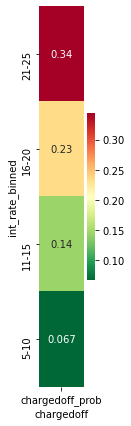

In [183]:
drawCrossTabHeatMap(loan_crosstab2, 'int_rate_binned', (1, 7))

#### Observation:
<font color='blue'>This shows that higher the Interest-Rate, risker the loan becomes</font>  

In [184]:
print('Number of observations in loan_crosstab2 = {0}'.format(loan_crosstab2.shape[0]))
print('Number of observations in loan = {0}'.format(loan.shape[0]))

Number of observations in loan_crosstab2 = 39319
Number of observations in loan = 39319


In [185]:
# After confirming that number of observations in both dataframes is same...
# for Segmented Analysis between int_rate and annual_inc
loan_seg=pd.concat(
  [loan.annual_inc, loan_crosstab2.int_rate_binned, loan_crosstab2.chargedoff], 
  axis=1, keys=['annual_inc', 'int_rate_binned', 'chargedoff']
)

loan_seg.head()

,annual_inc,int_rate_binned,chargedoff
0,24000.00,11-15,0
1,30000.00,16-20,1
2,12252.00,16-20,0
3,49200.00,11-15,0
4,80000.00,11-15,0


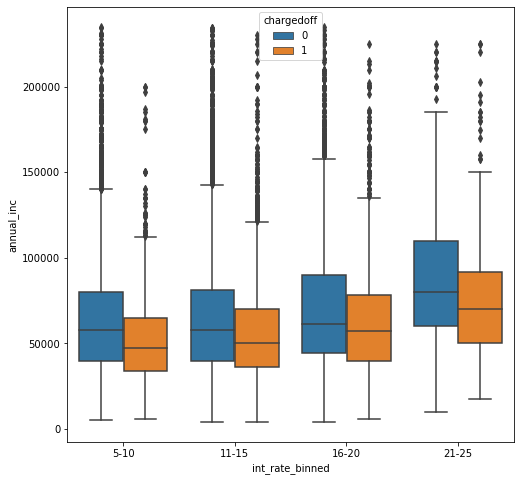

In [186]:
ax = plt.figure(figsize=(8, 8))
sns.boxplot(data=loan_seg, x='int_rate_binned', y='annual_inc', hue='chargedoff')
plt.show()

#### Observation:
<font color='blue'>The first 3 interest-rate brackets have similar borrower's annual income - median around 55000 USD.<br/>However, the highest interest-rate bracket has higher annual-income borrowers.<br/>Also, for any interest-rate bracket, those with lower annual-income, tend to default more. This trend is consistent across all brackets<br/>
</font>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

<font color='red'>Since higher interest rate is riskier, lets find out which variables are picking higher interest rate loans</font> <br/><br/>
<font color='brown'>UDF <strong>drawBiVarBarPlot</strong>: <br/>This plots bar for bivariate analysis - for a given variable against Grade/Term and InterestRate</font><br/>
<font color='blue'>Uses Pivot-Table and Bar Plot</font>


In [187]:
def drawBiVarBarPlot(df, col, fs=(15, 10) ):
  loan_pivot=pd.pivot_table(
    data=loan, 
    index=['grade','term'], 
    columns=[col], 
    values='int_rate', 
    aggfunc=np.median
  )

  # l=list(loan['term'].unique())
  # loan_pivot=loan_pivot[l].apply(lambda x: x/x.sum(),axis=1)
  loan_pivot.plot(kind='bar', figsize=(15, 10))

  plt.ylabel('int_rate',fontsize=10)

  plt.show()

<hr style="height:1px;border:none;color:#333;background-color:#333;">

Verification Status

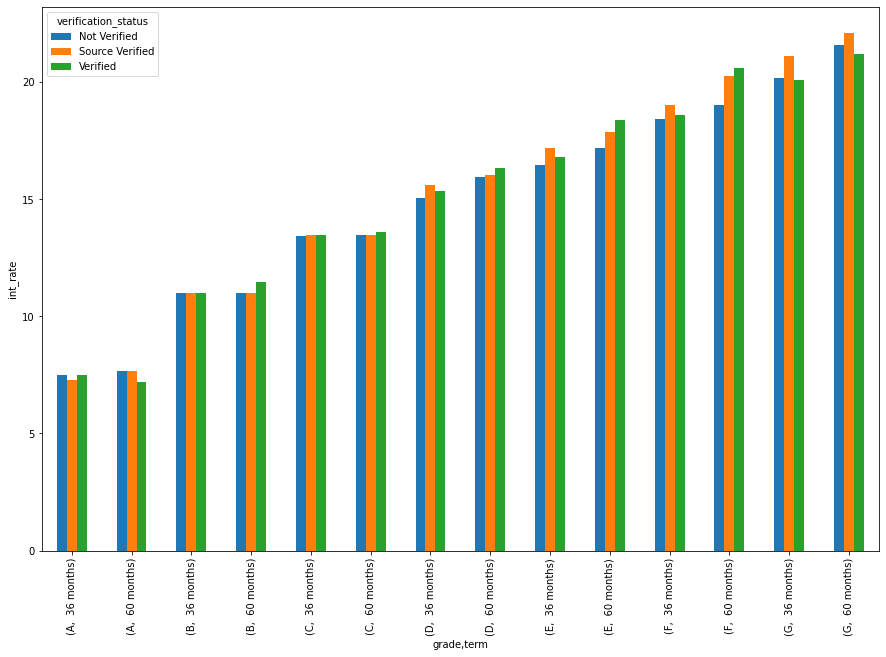

In [188]:
# Verification Status
drawBiVarBarPlot(loan, 'verification_status')

#### Observation:
<font color='blue'>Interest Rate is increasing in proportion to 'Garde/Term' for variable, Verification Status. <br/>No special case found</font>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

Home Ownership

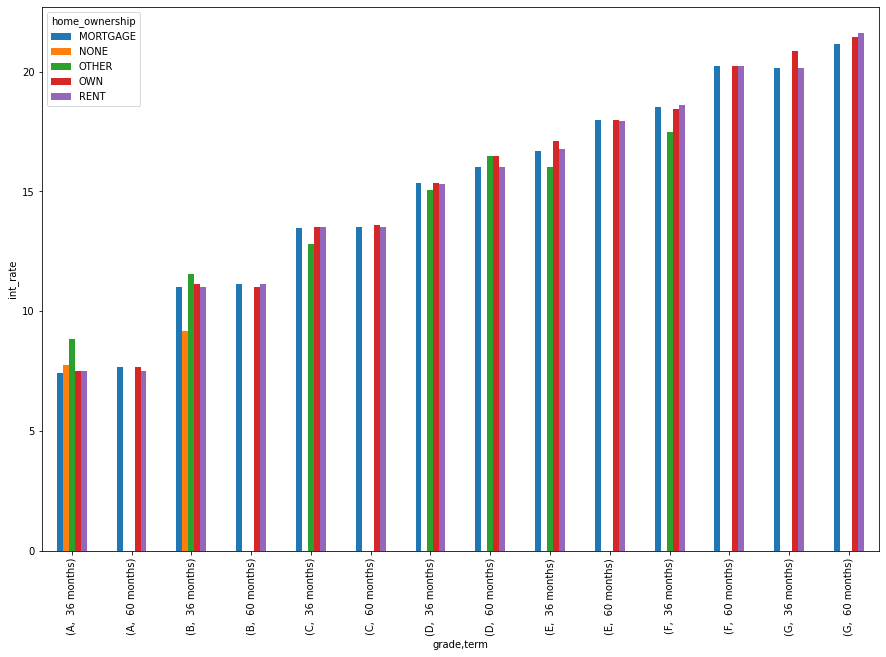

In [189]:
# Home Ownership
drawBiVarBarPlot(loan, 'home_ownership')

#### Observation:
<font color='blue'>Interest Rate is increasing in proportion to 'Grade/Term' for variable, Home Ownership. <br/>No special case found</font>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

Purpose

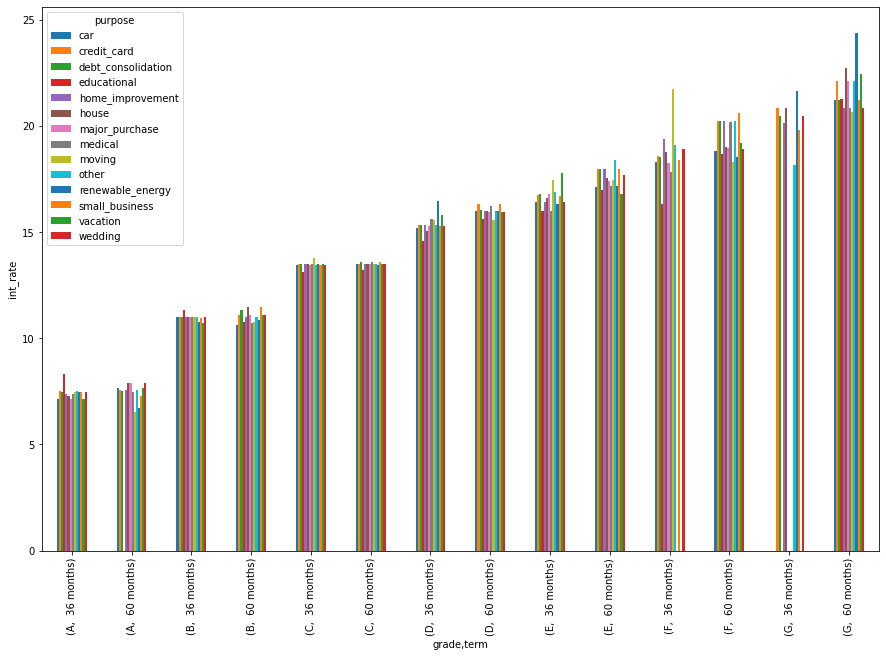

In [190]:
drawBiVarBarPlot(loan, 'purpose')

#### Observation:
<font color='blue'>Interest Rate is increasing in proportion to 'Grade/Term' for variable, Purpose. 
<br/><font><font color='red'>Note: 2 particular cases stand out in having higher interest rate than others:
<ul>
<li> Grade F/ 36 months Term -- <strong>Moving</strong> purpose
<li> Grade G/ 60 months Term -- <strong>Car</strong> purpose
</ul>
</font>
<hr style="height:1px;border:none;color:#333;background-color:#333;">

Employement Year

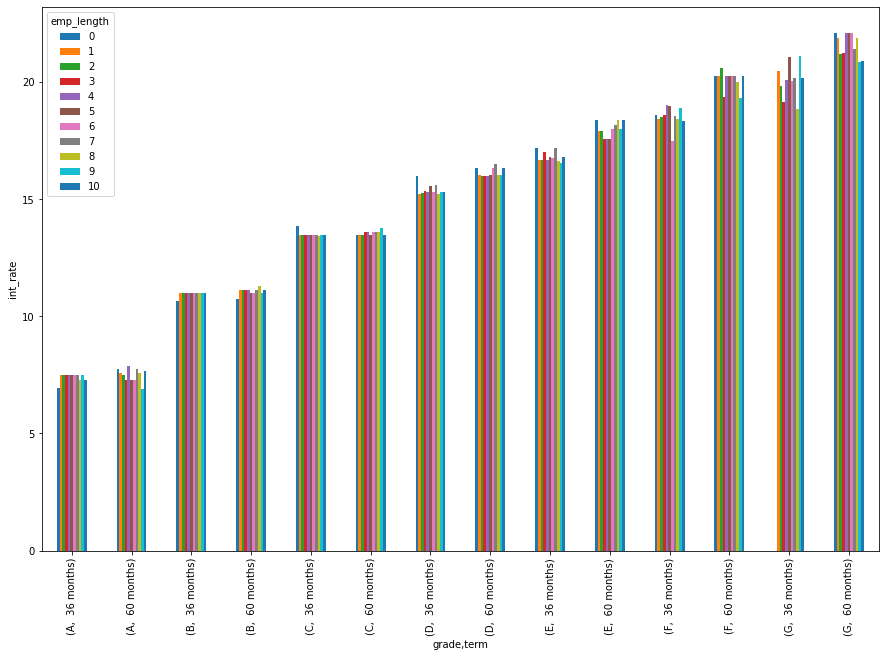

In [191]:
drawBiVarBarPlot(loan, 'emp_length')

#### Observation:
<font color='blue'>Interest Rate is increasing in proportion to 'Grade/Term' for variable, Employment Year. <br/>No special case found</font>
<hr style="height:1px;border:none;color:#333;background-color:#333;">


# Observations
<font color='red'><strong>1. term</strong></font><br/>
<font color='green'>Though Maximum number of loans belong to 3 year term,<br/>
    the probability of default is high for 60-month term</font>
<br/>
<font color='red'><strong>2. grade</strong></font><br/>
<font color='green'>Grade B was an exception to grab more number of loans than A.<br/>
However, the probability of default increase according to loan grades A through G</font>

<font color='red'><strong>3. emp_length</strong></font><br/>
<font color='green'>Loans tend to be taken proportionaly more in the early years of employment than later years.<br/>
And the emp_length less than 1 year, carry high risk of default</font>

<font color='red'><strong>4. purpose</strong></font><br/>
<font color='green'>Debt consolidation and credit card payments were the prominant reasons for taking loan<br/>
However, Purpose that carries highest risk of default is small_business</font>

<font color='red'><strong>5. interest rate</strong></font><br/>
<font color='green'>As Annual Income increase, the default rate decrease. Annual Income is negatively related to ChargedOff<br/>
More the interest-rate higher is the default rate<br/>
More the Loan Amount, higher is the chance to default.<br/>
High debt-to-income ratio implies higher the chance to default.<br/>
As person tends to default, his/her utilization of revolving credit tend to increase.<br/><br/>
All others except Interest-Rate, have loose positive correlation.<br/><br/>
Interest-Rate has significant positive correlation to ChargedOff variable.</font>

<font color='red'><strong>6. states</strong></font><br/>
<font color='green'>States CA, NY, FL, TX have maximum loans borrowed<br/>
However, the one that is by far the biggest contributor to default loans is NE - Nebraska<br/>
Though whole of the State cannot be defaulted; due to NE having high number of defaulters, addr_state need to be noted as one of the significant variable</font>

# Recommendations

<font color='blue'><strong>Target variable - Loan Status</strong><br/>The above analysis finds the below variables to be significant drivers to predict Defaulters<br/><br/>
<strong>Significant drivers</strong></font>
<ul>
 <li><font color='blue'><strong>Term</strong></font>  <a href=#Term-Significant>check</a></li>
 <li><font color='blue'><strong>Grade</strong></font>  <a href=#Grade-Significant>check</a></li>
 <li><font color='blue'><strong>Employment Year</strong></font>  <a href=#Employment_Year-Significant>check</a></li>
 <li><font color='blue'><strong>Purpose</strong></font>  <a href=#Purpose-Significant>check</a></li>
 <li><font color='blue'><strong>Interest Rate</strong></font>  <a href=#Interest_Rate-Significant>check</a></li>
 <li></li>
 <li><font color='blue'><strong>States</strong></font>  <a href=#States-Significant>check</a></li>
</ul>
